In [35]:
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time
import tensorflow as tf
import numpy as np
from numpy.linalg import norm

In [36]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [37]:
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [38]:
features = extract_features('/Users/veronikagavrilova/things/Диплом/book/data/fake-econom/0.jpg', model)
print(len(features))

1/1 [==============================] - 1s 865ms/step
100352


In [39]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list
root_dir = '/Users/veronikagavrilova/things/Диплом/book/data'
filenames = sorted(get_file_list(root_dir))

In [40]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

/var/folders/3v/krg2bns51pzbnh88wsl0r_3c0000gn/T/ipykernel_647/4263576671.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(filenames))):


  0%|          | 0/1031 [00:00<?, ?it/s]

1/1 [==============================] - 0s 115ms/step


In [41]:
pickle.dump(feature_list, open('features-resnet.pickle', 'wb'))
pickle.dump(filenames, open('filenames.pickle','wb'))

In [42]:
filenames = pickle.load(open('filenames.pickle', 'rb'))
feature_list = pickle.load(open('features-resnet.pickle', 'rb'))

In [43]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[0]])

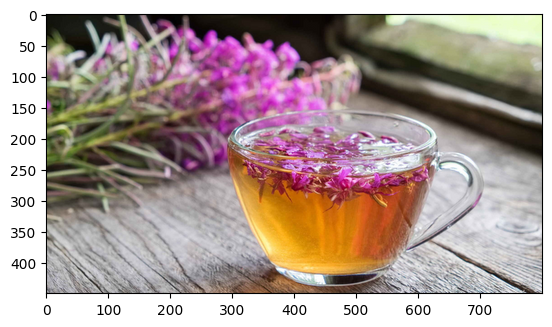

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
random_index = 90
distances, indices = neighbors.kneighbors([feature_list[random_index]])
plt.imshow(mpimg.imread(filenames[random_index]), interpolation='lanczos')

In [45]:
print([indices[0]])

[array([ 90, 221, 330, 612, 297])]


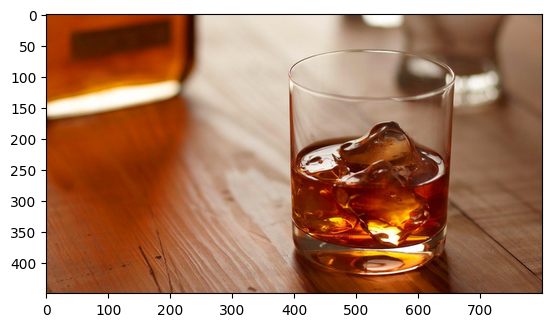

In [46]:
plt.imshow(mpimg.imread(filenames[indices[0][1]]), interpolation='lanczos')

In [47]:
for i in range(5):
    print(distances[0][i])

8.5600654e-08
1.1539507
1.2509655
1.2519201
1.2527906


In [48]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)

In [49]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)


Number of images =  1031
Number of features per image =  100352


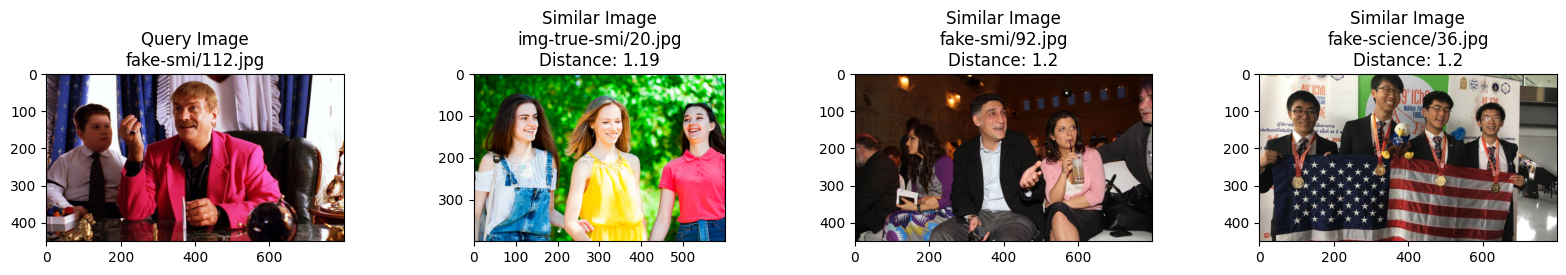

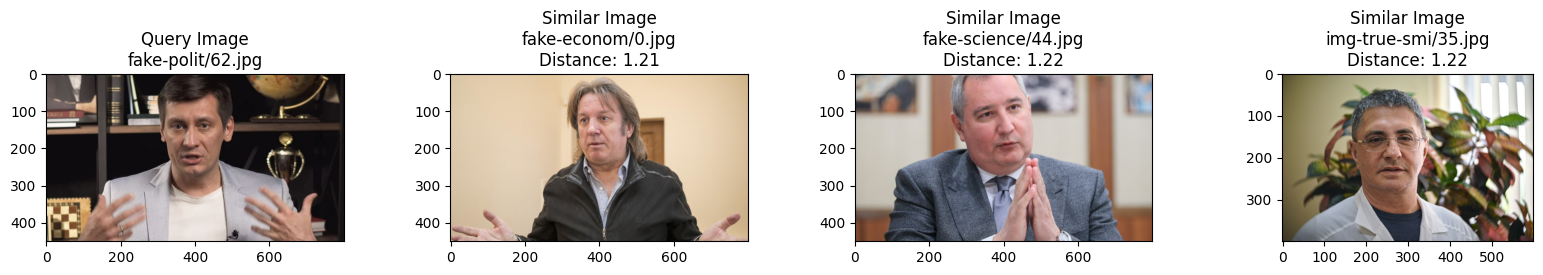

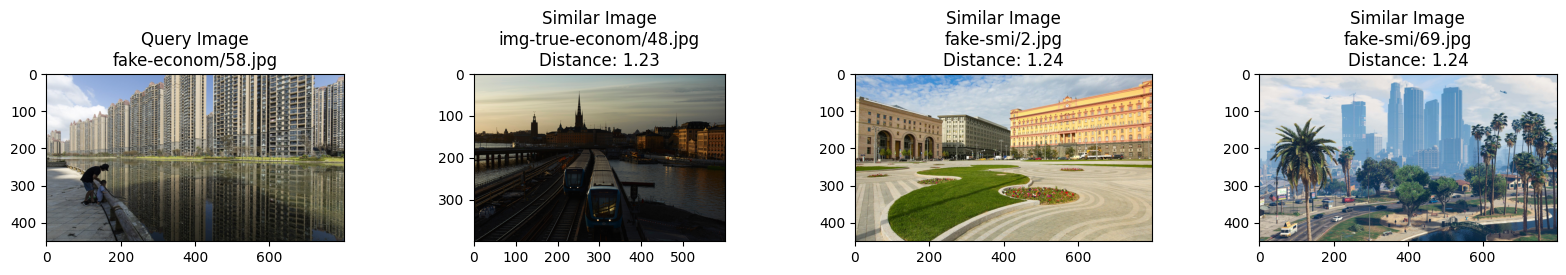

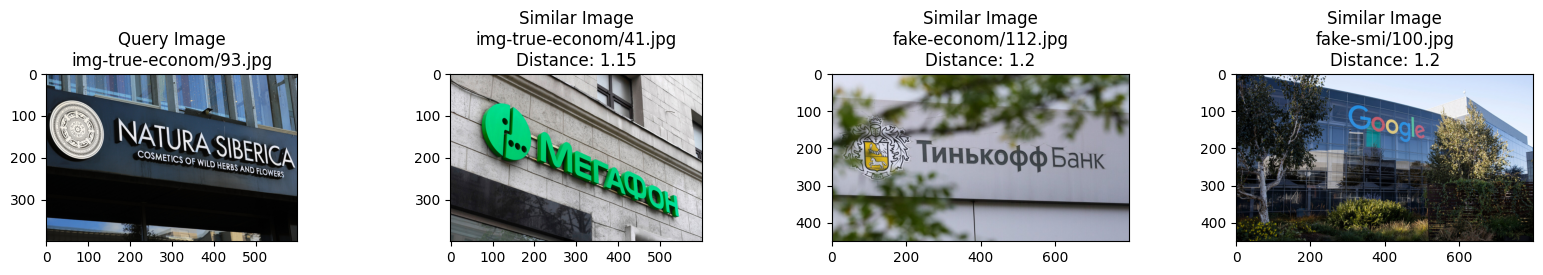

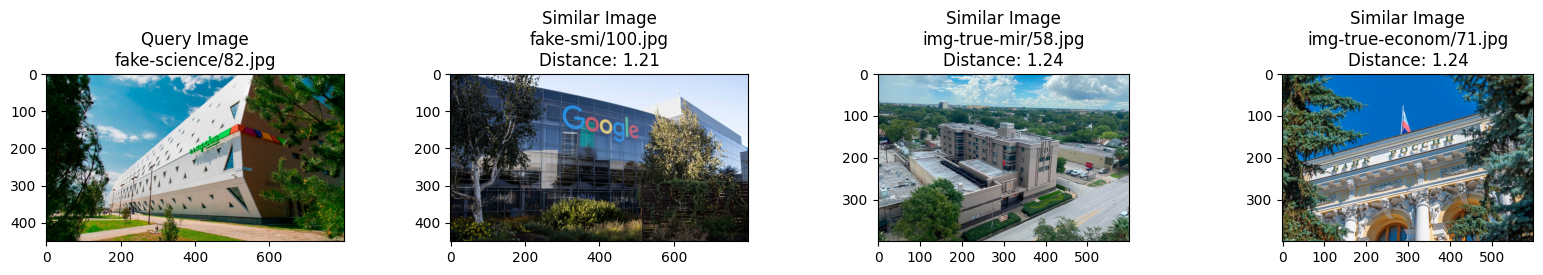

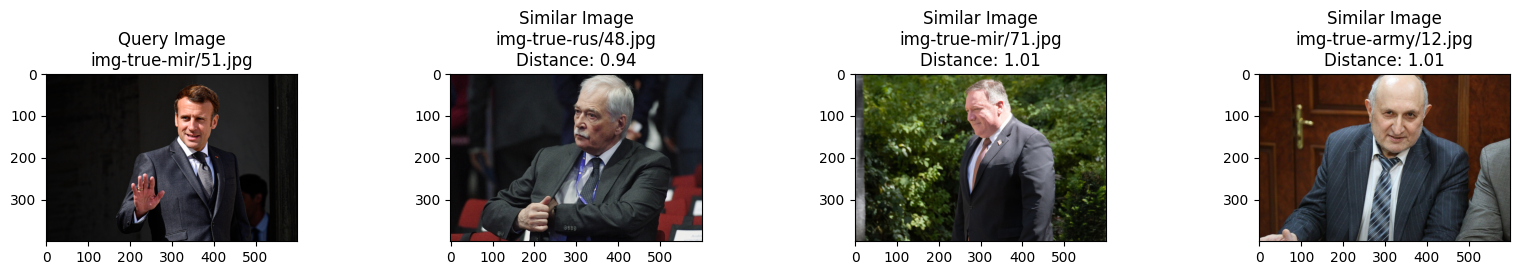

In [63]:
import random
for i in range(6):
    random_image_index = random.randint(0, num_images)
    distances, indices = neighbors.kneighbors(
        [feature_list[random_image_index]])
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])

In [51]:
neighbors = NearestNeighbors(n_neighbors=len(feature_list),
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors(feature_list)

# Calculating some stats
print("Median distance between all photos: ", np.median(distances))
print("Max distance between all photos: ", np.max(distances))
print("Median distance among most similar photos: ",
      np.median(distances[:, 2]))

Median distance between all photos:  1.3292338
Max distance between all photos:  1.404399
Median distance among most similar photos:  1.2094095
